In [1]:
import numpy as np

from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.mappers import ParityMapper, JordanWignerMapper, BravyiKitaevMapper
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.formats import MoleculeInfo

from qiskit_algorithms import NumPyMinimumEigensolver

from qiskit_algorithms.optimizers import SLSQP

from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit_algorithms import VQE
from qiskit.primitives import Estimator

In [2]:
driver = PySCFDriver(atom='H .0 .0 .0; H .0 .0 1; H 0.0 0.0 2.0; H 0.0 0.0 3.0')
molecule = driver.run()

mappers = [
    ('Jordan-Wigner', JordanWignerMapper()),
    ('Parity', ParityMapper(num_particles=molecule.num_particles)),
    ('Bravyi-Kitaev', BravyiKitaevMapper())
]

In [3]:
#transformer = FreezeCoreTransformer()
#molecule = transformer.transform(molecule)
hamiltonian = molecule.hamiltonian.second_q_op()

for name, mapper in mappers:
    print(f'{name}:')

    qubit_op = mapper.map(hamiltonian)
    print(f'--- Number of qubits needed: {qubit_op.num_qubits}, Number of paulis: {qubit_op.size}')

    algo = NumPyMinimumEigensolver()
    algo.filter_criterion = molecule.get_default_filter_criterion()
    solver = GroundStateEigensolver(mapper, algo)
    result = solver.solve(molecule)
    print(f'--- NumPyMinimumEigensolver result: {result.total_energies[0]} Ha')

    optimizer = SLSQP(maxiter=10000, ftol=1e-9)
    # UCCSD = unitary coupled cluster singles and doubles
    # anstatz = TwoLocal 
    # ansatz = EfficientSU2
    ansatz = UCCSD(
        molecule.num_spatial_orbitals,
        molecule.num_particles,
        mapper,
        initial_state=HartreeFock(
            molecule.num_spatial_orbitals,
            molecule.num_particles,
            mapper,
        ),
    )
    vqe = VQE(Estimator(), ansatz, optimizer)
    vqe.initial_point = [0] * ansatz.num_parameters
    algo = GroundStateEigensolver(mapper, vqe)
    result = algo.solve(molecule)
    print(f'--- VQE result: {result.total_energies[0]} Ha')
# Ha = Hartree unit of energy for quantum chemistry 

Jordan-Wigner:
--- Number of qubits needed: 8, Number of paulis: 185
--- NumPyMinimumEigensolver result: -2.166387448634758 Ha


/tmp/ipykernel_1552/2623258341.py:31: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe = VQE(Estimator(), ansatz, optimizer)


--- VQE result: -2.1663080191216544 Ha
Parity:
--- Number of qubits needed: 6, Number of paulis: 165
--- NumPyMinimumEigensolver result: -2.166387448634757 Ha
--- VQE result: -2.166308019147033 Ha
Bravyi-Kitaev:
--- Number of qubits needed: 8, Number of paulis: 185
--- NumPyMinimumEigensolver result: -2.166387448634758 Ha
--- VQE result: -2.1663080190815416 Ha


In [4]:
distances  = [0.5 + 0.025*x  for x in range(0, 20)]

def compute_energies(algorithm, distances):
    print(f'{algorithm}, processing step __', end='')

    energies = []
    hf_energies = []
    estimator = Estimator()

    for i, d in enumerate(distances):
        print('\b\b{:2d}'.format(i), end='', flush=True)

        info = MoleculeInfo(["H", "H"], [(0.0, 0.0, 0.0), (0.0, 0.0, d)])
        driver = PySCFDriver.from_molecule(info, basis="sto3g")
        molecule = driver.run()
        mapper = JordanWignerMapper()
        tapered_mapper = molecule.get_tapered_mapper(mapper)

        if algorithm == 'NumPyMinimumEigensolver':
            algo = NumPyMinimumEigensolver()
            algo.filter_criterion = molecule.get_default_filter_criterion()
            solver = GroundStateEigensolver(mapper, algo)
            result = solver.solve(molecule)
            hf_energies.append(result.hartree_fock_energy)
            energies.append(result.total_energies[0])

        elif algorithm == 'VQE':
            optimizer = SLSQP(maxiter=10000, ftol=1e-9)
            ansatz = UCCSD(
                molecule.num_spatial_orbitals,
                molecule.num_particles,
                tapered_mapper,
                initial_state=HartreeFock(
                    molecule.num_spatial_orbitals,
                    molecule.num_particles,
                    tapered_mapper,
                ),
            )
            vqe = VQE(estimator, ansatz, optimizer)
            algo = GroundStateEigensolver(tapered_mapper, vqe)
            result = algo.solve(molecule)
            energies.append(result.total_energies[0])
            hf_energies.append(result.hartree_fock_energy)

    print(' --- complete')
    return hf_energies, energies

In [5]:
hf_energies, npme_energies = compute_energies('NumPyMinimumEigensolver', distances)
_, vqe_energies = compute_energies('VQE', distances)

NumPyMinimumEigensolver, processing step  0

/tmp/ipykernel_1552/1797399010.py:8: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


19 --- complete
VQE, processing step 19 --- complete


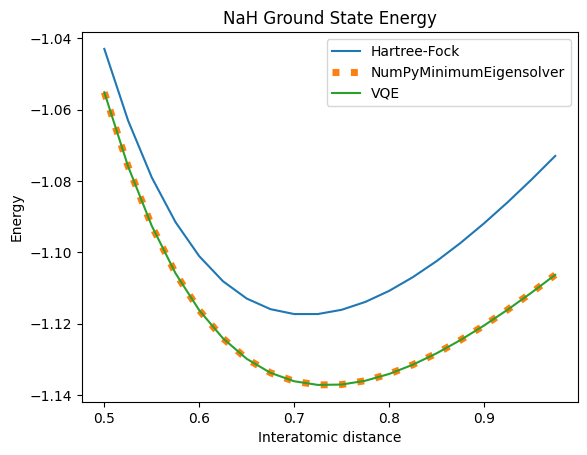

In [6]:
import matplotlib.pyplot as plt

plt.plot(distances, hf_energies, label='Hartree-Fock')
plt.plot(distances, npme_energies, label='NumPyMinimumEigensolver', linestyle = 'dotted', linewidth=5.0)
plt.plot(distances, vqe_energies, label='VQE')

plt.xlabel('Interatomic distance')
plt.ylabel('Energy')
plt.title('NaH Ground State Energy')

plt.legend(loc='upper right')

plt.show()